# <a href="https://thetahat.ru/courses/ph-ds-2024-aut">Phystech@DataScience</a>
## Семинар 8 (Часть 2)

**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_pds_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb`.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* **Код из рассказанных на занятиях ноутбуков можно использовать без ограничений.**

**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $\LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.

In [2]:
# Bot check

# HW_ID: phds_sem8_2
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [2]:
!pip install catboost

In [3]:
!pip install xgboost

In [4]:
!pip install lightgbm

In [5]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.datasets import fetch_california_housing

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

sns.set(font_scale=1.8, palette='Set2')

##  Сравнение различных бустингов и случайного леса

###  №1 Задача регрессии на предсказание цены квартир

Исследуем зависимость качества предсказаний градиентного бустинга и случайного леса в зависимости от числа базовых моделей на примере задаче регрессии. Для случайного леса будем использовать класс `RandomForestRegressor` библиотеки `sklearn`. В качестве таргета будет предсказание цены квартир в Калифорнии в зависимости от различных параметров.

In [6]:
housing = fetch_california_housing()
print("Признаки:",housing.feature_names)
X, y = housing.data, housing.target

Признаки: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


Разобьём данные на обучающую выборку и на тестовую, выделив на тест 25% данных.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [8]:
def plot_compare_estimators(estimator_labels, param_grid, train_metrics,
                            test_metrics, param_label='', metrics_label='',
                            title=''):
    '''Функция для построения графиков зависимости целевой метрики
    от некоторого параметра модели на обучающей и на валидационной
    выборке.

    :param estimator_labels: массив названий моделей
    :param param_grid: значения исследуемого параметра
    :param train_metrics: массив, где i-ый элемент -
        это массив значений метрики на обучающей выборке для i-ой модели
    :param test_metrics: массив, где i-ый элемент -
        это массив значений метрики на валидационной выборке для i-ой модели
    :param param_label: названия параметра
    :param metrics_label: название метрики
    :param title: заголовок для графика
    '''

    plt.figure(figsize=(20, 7))

    for estimator_id in range(len(estimator_labels)):
        label = estimator_labels[estimator_id]
        plt.plot(
            param_grid, train_metrics[estimator_id],
            label=f'{label} train', linewidth=3
        )
        plt.plot(
            param_grid, test_metrics[estimator_id],
            label=f'{label} test', linewidth=3
        )

    plt.legend()
    plt.xlabel(param_label)
    plt.ylabel(metrics_label)
    plt.title(title, fontsize=20)

#### Обучим случайный лес для разного числа деревьев и посчитаем `mse`.

In [9]:
rf_mse_train = []  # метрика на трейне
rf_mse_test = []  # метрика на тесте
n_estimators_grid = range(1, 300, 10)

for n_estimators in tqdm(n_estimators_grid):
    model = RandomForestRegressor(n_estimators = n_estimators)
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    rf_mse_train.append(mse(y_pred_test, y_test))
    rf_mse_test.append(mse(y_pred_train, y_train))


  0%|          | 0/30 [00:00<?, ?it/s]

Обучим градиентный бустинг для разного числа деревьев и посчитаем `mse`.

In [12]:
boosting_mse_train = []
boosting_mse_test = []

for n_estimators in tqdm(n_estimators_grid):
    regressor = GradientBoostingRegressor(learning_rate=1, n_estimators=n_estimators)
    regressor.fit(X_train, y_train)
    y_train_pred = regressor.predict(X_train)
    mse_train = mse(y_train, y_train_pred)
    boosting_mse_train.append(mse_train)
    y_test_pred = regressor.predict(X_test)
    mse_test = mse(y_test, y_test_pred)
    boosting_mse_test.append(mse_test)

  0%|          | 0/30 [00:00<?, ?it/s]

Обучим СatBoost для разного числа деревьев и посчитаем `mse`.

In [13]:
catboost_mse_train = []
catboost_mse_test = []

for n_estimators in tqdm(n_estimators_grid):
    catboost_regressor = CatBoostRegressor(iterations=n_estimators, learning_rate=1, verbose=0)
    catboost_regressor.fit(X_train, y_train)

    y_train_pred = catboost_regressor.predict(X_train)
    mse_train = mse(y_train, y_train_pred)
    catboost_mse_train.append(mse_train)

    y_test_pred = catboost_regressor.predict(X_test)
    mse_test = mse(y_test, y_test_pred)
    catboost_mse_test.append(mse_test)

  0%|          | 0/30 [00:00<?, ?it/s]

Обучим LGBM для разного числа деревьев и посчитаем `mse`.

In [14]:
lgbm_mse_train = []
lgbm_mse_test = []

for n_estimators in tqdm(n_estimators_grid):
    lgbm_regressor = LGBMRegressor(n_estimators=n_estimators, learning_rate=1, verbose=-1)
    lgbm_regressor.fit(X_train, y_train)

    y_train_pred = lgbm_regressor.predict(X_train)
    mse_train = mse(y_train, y_train_pred)
    lgbm_mse_train.append(mse_train)

    y_test_pred = lgbm_regressor.predict(X_test)
    mse_test = mse(y_test, y_test_pred)
    lgbm_mse_test.append(mse_test)

  0%|          | 0/30 [00:00<?, ?it/s]

Построим график зависимости `mse` от количества базовых моделей.

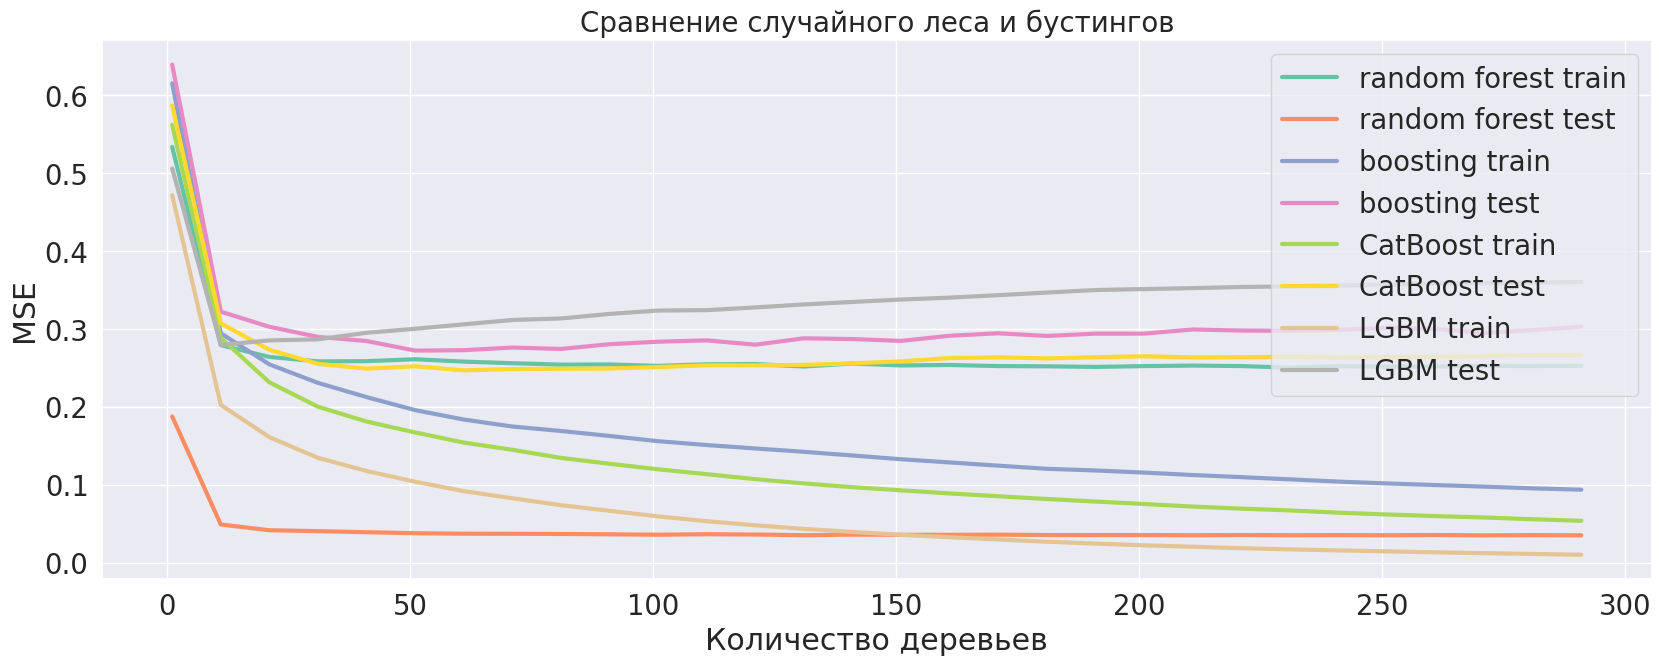

In [15]:
plot_compare_estimators(
    ['random forest', 'boosting', "CatBoost", "LGBM"], n_estimators_grid,
    [rf_mse_train, boosting_mse_train, catboost_mse_train, lgbm_mse_train],
    [rf_mse_test, boosting_mse_test, catboost_mse_test,lgbm_mse_test],
    'Количество деревьев', 'MSE',
    'Сравнение случайного леса и бустингов'
)

**Вывод.** графики ведут себя более менее похоже, mse уменьшается при увеличении количества деревьев. только lgbm test и catboost test начинают расти в какой-то момент, вероятно, из-за переобучения. самое маленькое mse у lgbm train. у случайного леса на train и test значения mse сильно отличается, у остальных на тестовой и тренировочной выборке на маленьком количестве деревьев значения mse очень близки.

#### Сравним времена обучения и предсказания случайного леса и бустингов с параметрами по умолчанию:

Градиентный бустинг

In [17]:
%%timeit

regressor_boosting = GradientBoostingRegressor().fit(X_train, y_train)

5.49 s ± 1.73 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
regressor_boosting = GradientBoostingRegressor().fit(X_train, y_train)

In [21]:
%%timeit

y_pred_regressor_boosting = regressor_boosting.predict(X_train)

24.1 ms ± 893 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Случайный лес

In [23]:
%%timeit

regressor_forest = RandomForestRegressor(n_jobs=-1).fit(X_train, y_train)

12 s ± 3.14 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
regressor_forest = RandomForestRegressor(n_jobs=-1).fit(X_train, y_train)

In [25]:
%%timeit

y_pred_regressor_forest = regressor_forest.predict(X_train)

401 ms ± 130 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


СatBoost regressor

In [26]:
%%timeit

catboost = CatBoostRegressor(silent=True).fit(X_train, y_train)

6.25 s ± 2.91 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
catboost = CatBoostRegressor(silent=True).fit(X_train, y_train)

In [28]:
%%timeit

y_pred_catboost = catboost.predict(X_train)

67.7 ms ± 21.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


LGBM regressor

In [29]:
%%timeit

lgbm = LGBMRegressor(silent=True).fit(X_train, y_train)

The slowest run took 6.15 times longer than the fastest. This could mean that an intermediate result is being cached.
1.04 s ± 497 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
lgbm = LGBMRegressor(silent=True).fit(X_train, y_train)

In [31]:
%%timeit

y_pred_lgbm = lgbm.predict(X_train)

67.2 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Вывод:** дольше всего обучает и предсказывает случаный лес, это и ожидалось.

### №2 Задача на классификацию студентов

Сделаем аналогичный эксперимент с датасетом для классификации на 3 класса студентов (отчислен, закончил обучение, продолжает обучение). Целевой колонкой является `Target`.

In [33]:
students = pd.read_csv("/content/students_dropout_succes.csv")
students.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [34]:
X = students.drop(columns = ["Target"])
y = students["Target"]

Разобьём данные на обучающую и тестовую выборки, под тестовую выделим 30%. Обязательно зафиксируйте `random_state` для воспроизводимости результатов.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Обучим случайный лес для разного числа деревьев и посчитаем метрику `f1_score`.

In [38]:
rf_accuracy_train = []
rf_accuracy_test = []
n_estimators_grid = range(1, 300, 25)

for n_estimators in tqdm(n_estimators_grid):
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf_classifier.fit(X_train, y_train)

    y_train_pred = rf_classifier.predict(X_train)
    f1_train = f1_score(y_train, y_train_pred, average='micro')
    rf_accuracy_train.append(f1_train)

    y_test_pred = rf_classifier.predict(X_test)
    f1_test = f1_score(y_test, y_test_pred, average='micro')
    rf_accuracy_test.append(f1_test)

  0%|          | 0/12 [00:00<?, ?it/s]

Обучим градиентный бустинг для разного числа деревьев и посчитаем метрику `f1_score`.

In [42]:
boosting_accuracy_train = []
boosting_accuracy_test = []
n_estimators_grid = range(1, 300, 25)

for n_estimators in tqdm(n_estimators_grid):
    regressor = GradientBoostingClassifier( n_estimators=n_estimators)
    regressor.fit(X_train, y_train)
    y_train_pred = regressor.predict(X_train)
    f1_train = f1_score(y_train, y_train_pred, average='micro')
    boosting_accuracy_train.append(f1_train)

    y_test_pred = regressor.predict(X_test)
    f1_test = f1_score(y_test, y_test_pred, average='micro')
    boosting_accuracy_test.append(f1_test)

  0%|          | 0/12 [00:00<?, ?it/s]

Обучим CatBoost для разного числа деревьев и посчитаем метрику `f1_score`.

In [43]:
catboost_f1_train = []
catboost_f1_test = []

for n_estimators in tqdm(n_estimators_grid):
    catboost_regressor = CatBoostClassifier(iterations=n_estimators, learning_rate=1, verbose=0)
    catboost_regressor.fit(X_train, y_train)

    y_train_pred = catboost_regressor.predict(X_train)
    f1_train = f1_score(y_train, y_train_pred, average='micro')
    catboost_f1_train.append(f1_train)

    y_test_pred = catboost_regressor.predict(X_test)
    f1_test = f1_score(y_test, y_test_pred, average='micro')
    catboost_f1_test.append(f1_test)

  0%|          | 0/12 [00:00<?, ?it/s]

Обучим LGBM для разного числа деревьев и посчитаем метрику `f1_score`.

In [45]:
lgbm_f1_train = []
lgbm_f1_test = []

for n_estimators in tqdm(n_estimators_grid):
    lgbm_regressor = LGBMClassifier(n_estimators=n_estimators, verbose=-1)
    lgbm_regressor.fit(X_train, y_train)

    y_train_pred = lgbm_regressor.predict(X_train)
    f1_train = f1_score(y_train, y_train_pred, average='micro')
    lgbm_f1_train.append(f1_train)

    y_test_pred = lgbm_regressor.predict(X_test)
    f1_test = f1_score(y_test, y_test_pred, average='micro')
    lgbm_f1_test.append(f1_test)

  0%|          | 0/12 [00:00<?, ?it/s]

Построим график зависимости `f1_score` от количества базовых моделей.

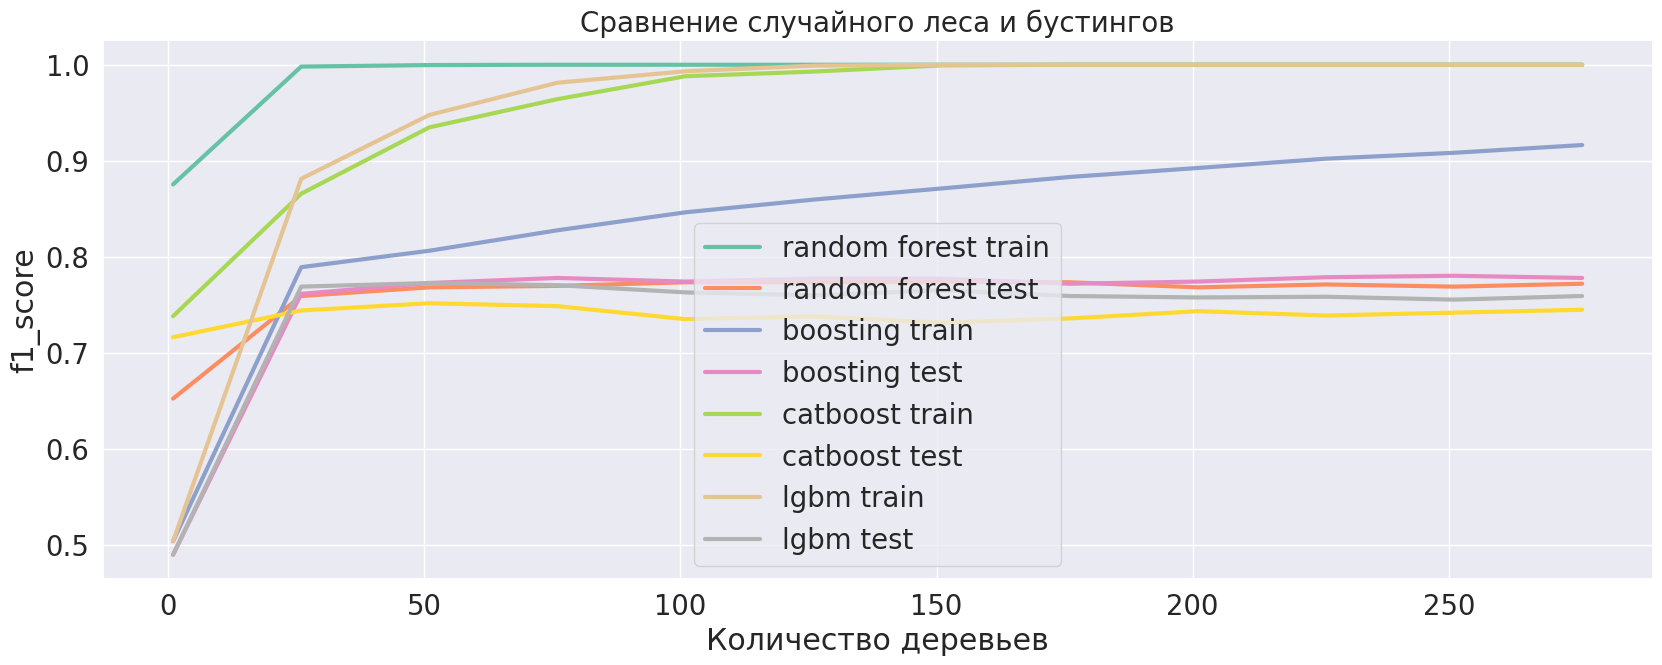

In [46]:
plot_compare_estimators(
    ['random forest', 'boosting', "catboost", "lgbm"], n_estimators_grid,
    [rf_accuracy_train, boosting_accuracy_train, catboost_f1_train,lgbm_f1_train],
    [rf_accuracy_test, boosting_accuracy_test, catboost_f1_test, lgbm_f1_test],
    'Количество деревьев', 'f1_score',
    'Сравнение случайного леса и бустингов'
)

**Вывод.** самое лучшее значение f1_score показывает случаный лес на тренировочной выборке, на тестовой значение намного ниже, даже одно из самых худших. также catboost показывает хорошее f1_score, только позже. остальные значения f1_score похожи.

## AutoML &mdash; LightAutoMl Framework

LAMA AutoML (Automated Machine Learning) — это система автоматизированного машинного обучения, разработанная для упрощения процесса создания и оптимизации моделей машинного обучения. Она автоматизирует следующее:

1. **Подготовка данных**. Автоматическая предобработка данных, включая нормализацию, заполнение пропущенных значений и другие преобразования.
2. **Выбор признаков**. Автоматический отбор наиболее значимых признаков для модели.
3. **Выбор модели**. Ансамблированный выбор комбинаций наилучших моделей.
4. **Настройка гиперпараметров**. Автоматическая оптимизация гиперпараметров.
5. **Оценка модели**. Автоматическая оценка производительности модели с использованием кросс-валидации и других методов.

то есть 70% процентов наших текущих задач

![image.png](attachment:image.png)

Подробнее можно прочитать тут: https://lightautoml.readthedocs.io/en/latest/pages/tutorials/Tutorial_1_basics.html

Для начала скачаем библиотеку (может занять много времени, можно попробовать ставить в Google Collab)

In [1]:
!pip install -U lightautoml

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.4/416.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.7/215.7 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 59.3 MB/s eta 0:00:00
   ━━

Импортируем нужные нам библиотеки

In [47]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

Для LAMA целевая колонка задается по другому, поэтому разобьем наш датасет на train и test

In [49]:
students = pd.read_csv("/content/students_dropout_succes.csv")
train_data, test_data = train_test_split(students, test_size = 0.3, random_state=42)

Теперь зададим целевую колонку с помощью атрибута `roles`

In [50]:
roles = {
    'target': 'Target', #целевая колонка тут Target
}

#### Создание объекта Task

Сначала нам нужно создать объект `Task` — класс, чтобы указать, какую задачу должна решать модель LightAutoML с определенными потерями и метрикой, если это необходимо (более подробную информацию можно найти в документации).

Доступные типы задач

1. **'binary'** - для бинарной классификации.
2. **'reg'** - для регрессии.
3. **'multiclass'** - для многоклассовой классификации.
4. **'multi:reg'** - для множественной регрессии.
5. **'multilabel'** - для многомарковой классификации.

In [55]:
automl = TabularAutoML(
    task = Task('multiclass'), #введите, какую задачу мы собираемся решать
    timeout = 60 #введите количество времени, в течении которого будет обучаться LAMA
)

Теперь запустим обучение:

In [56]:
%%time
out_of_fold_predictions = automl.fit_predict(train_data, roles = roles, verbose = 1)

[16:50:52] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[16:50:52] Task: multiclass



INFO:lightautoml.automl.presets.base:Task: multiclass



[16:50:52] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[16:50:52] - time: 60.00 seconds


INFO:lightautoml.automl.presets.base:- time: 60.00 seconds


[16:50:52] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[16:50:52] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[16:50:52] Train data shape: (3096, 37)



INFO:lightautoml.reader.base:Train data shape: (3096, 37)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[16:50:59] Layer 1 train process start. Time left 52.76 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 52.76 secs


[16:51:00] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [64, 65, 66, 67, 68, 69], 'embed_sizes': array([20, 14, 19, 16, 17,  9], dtype=int32), 'data_size': 70}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -0.891758126737259
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -0.7525749150523655
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -0.7042510089183077
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = -0.6330539722542231
INFO3:lightautoml.ml_algo.torch_based.linear_model:Lin

[16:51:02] Time limit exceeded after calculating fold 1



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 1



[16:51:02] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.5522305339755282


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.5522305339755282


[16:51:02] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[16:51:02] Time left 49.70 secs



INFO:lightautoml.automl.base:Time left 49.70 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 0.668751
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 0.592493
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's multi_logloss: 0.562445
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's multi_logloss: 0.548247
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's multi_logloss: 0.539351
DEBUG:lightautoml.ml_algo.boost_lgbm:[600]	valid's multi_logloss: 0.535531
DEBUG:lightautoml.ml_algo.boost_lgbm:[700]	valid's multi_logloss: 0.533457
DEBUG:lightautoml.ml_algo.boost_lgbm:[800]	valid's multi_logloss: 0.532127
DEBUG:lightautoml.ml_algo.boost_lgbm:[900]	valid's multi_logloss: 0.532313
DEBUG:lightautoml.ml_algo.boost_lgbm:[1000]	valid's multi_logloss: 0.532317
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[848]	valid's multi_logloss

[16:51:05] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[16:51:06] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 0.660901
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 0.587563
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's multi_logloss: 0.563149
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's multi_logloss: 0.553519
DEBUG

[16:51:13] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[16:51:13] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.5474183965656664


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.5474183965656664


[16:51:13] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[16:51:13] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'GPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'devices': '0'}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 1.0689123	test: 1.0702097	best: 1.0702097 (0)	total: 7.87ms	remaining: 23.6s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 0.5093050	test: 0.5927490	best: 0.5927490 (100)	total: 606ms	remaining: 17.4s
DEBUG:lightautoml.ml_algo.b

[16:51:26] Time limit exceeded after calculating fold 1



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 1



[16:51:26] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.5304055870867134


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.5304055870867134


[16:51:26] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[16:51:26] Time left 26.60 secs



INFO:lightautoml.automl.base:Time left 26.60 secs



[16:51:26] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



INFO:lightautoml.automl.base:Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



[16:51:26] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[16:51:26] Blending: optimization starts with equal weights and score -0.5284976221161176


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score -0.5284976221161176


[16:51:26] Blending: iteration 0: score = -0.5266161316822243, weights = [0.1929027  0.23062244 0.57647485]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = -0.5266161316822243, weights = [0.1929027  0.23062244 0.57647485]


[16:51:26] Blending: iteration 1: score = -0.5266155267859196, weights = [0.18956855 0.23936737 0.5710641 ]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = -0.5266155267859196, weights = [0.18956855 0.23936737 0.5710641 ]


[16:51:26] Blending: iteration 2: score = -0.5266155267859196, weights = [0.18956855 0.23936737 0.5710641 ]


INFO:lightautoml.automl.blend:Blending: iteration 2: score = -0.5266155267859196, weights = [0.18956855 0.23936737 0.5710641 ]


[16:51:26] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[16:51:26] Automl preset training completed in 33.68 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 33.68 seconds



[16:51:26] Model description:
Final prediction for new objects (level 0) = 
	 0.18957 * (2 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.23937 * (1 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.57106 * (2 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.18957 * (2 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.23937 * (1 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.57106 * (2 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) 



CPU times: user 34.7 s, sys: 7.16 s, total: 41.9 s
Wall time: 33.8 s


Какие модели используются в итоговом предсказании и какими весами?
2  models LinearL2 c весом 0.18957.
1  model LightGBM c весом  0.23937.
2	 models CatBoost с весом 0.57106.

Сделаем обратный маппинг классов (из LabelEncoding в слова)

In [57]:
mapping = automl.reader.class_mapping
def map_class(x):
    return mapping[x]
mapped = np.vectorize(map_class)

Посмотрим на результаты обучения

In [58]:
%%time

test_predictions = automl.predict(test_data)

print(f'Train F1 score: {f1_score(mapped(train_data[roles["target"]].values), np.argmax(out_of_fold_predictions.data, axis = 1), average = "weighted")}')
print(f'Test F1 score: {f1_score(mapped(test_data[roles["target"]].values), np.argmax(test_predictions.data, axis = 1), average = "weighted")}')

Train F1 score: 0.562233116614192
Test F1 score: 0.7619019023772201
CPU times: user 625 ms, sys: 5.91 ms, total: 631 ms
Wall time: 630 ms


Посмотрите на важность фичей:

CPU times: user 372 ms, sys: 126 ms, total: 498 ms
Wall time: 365 ms


<Axes: xlabel='Feature'>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


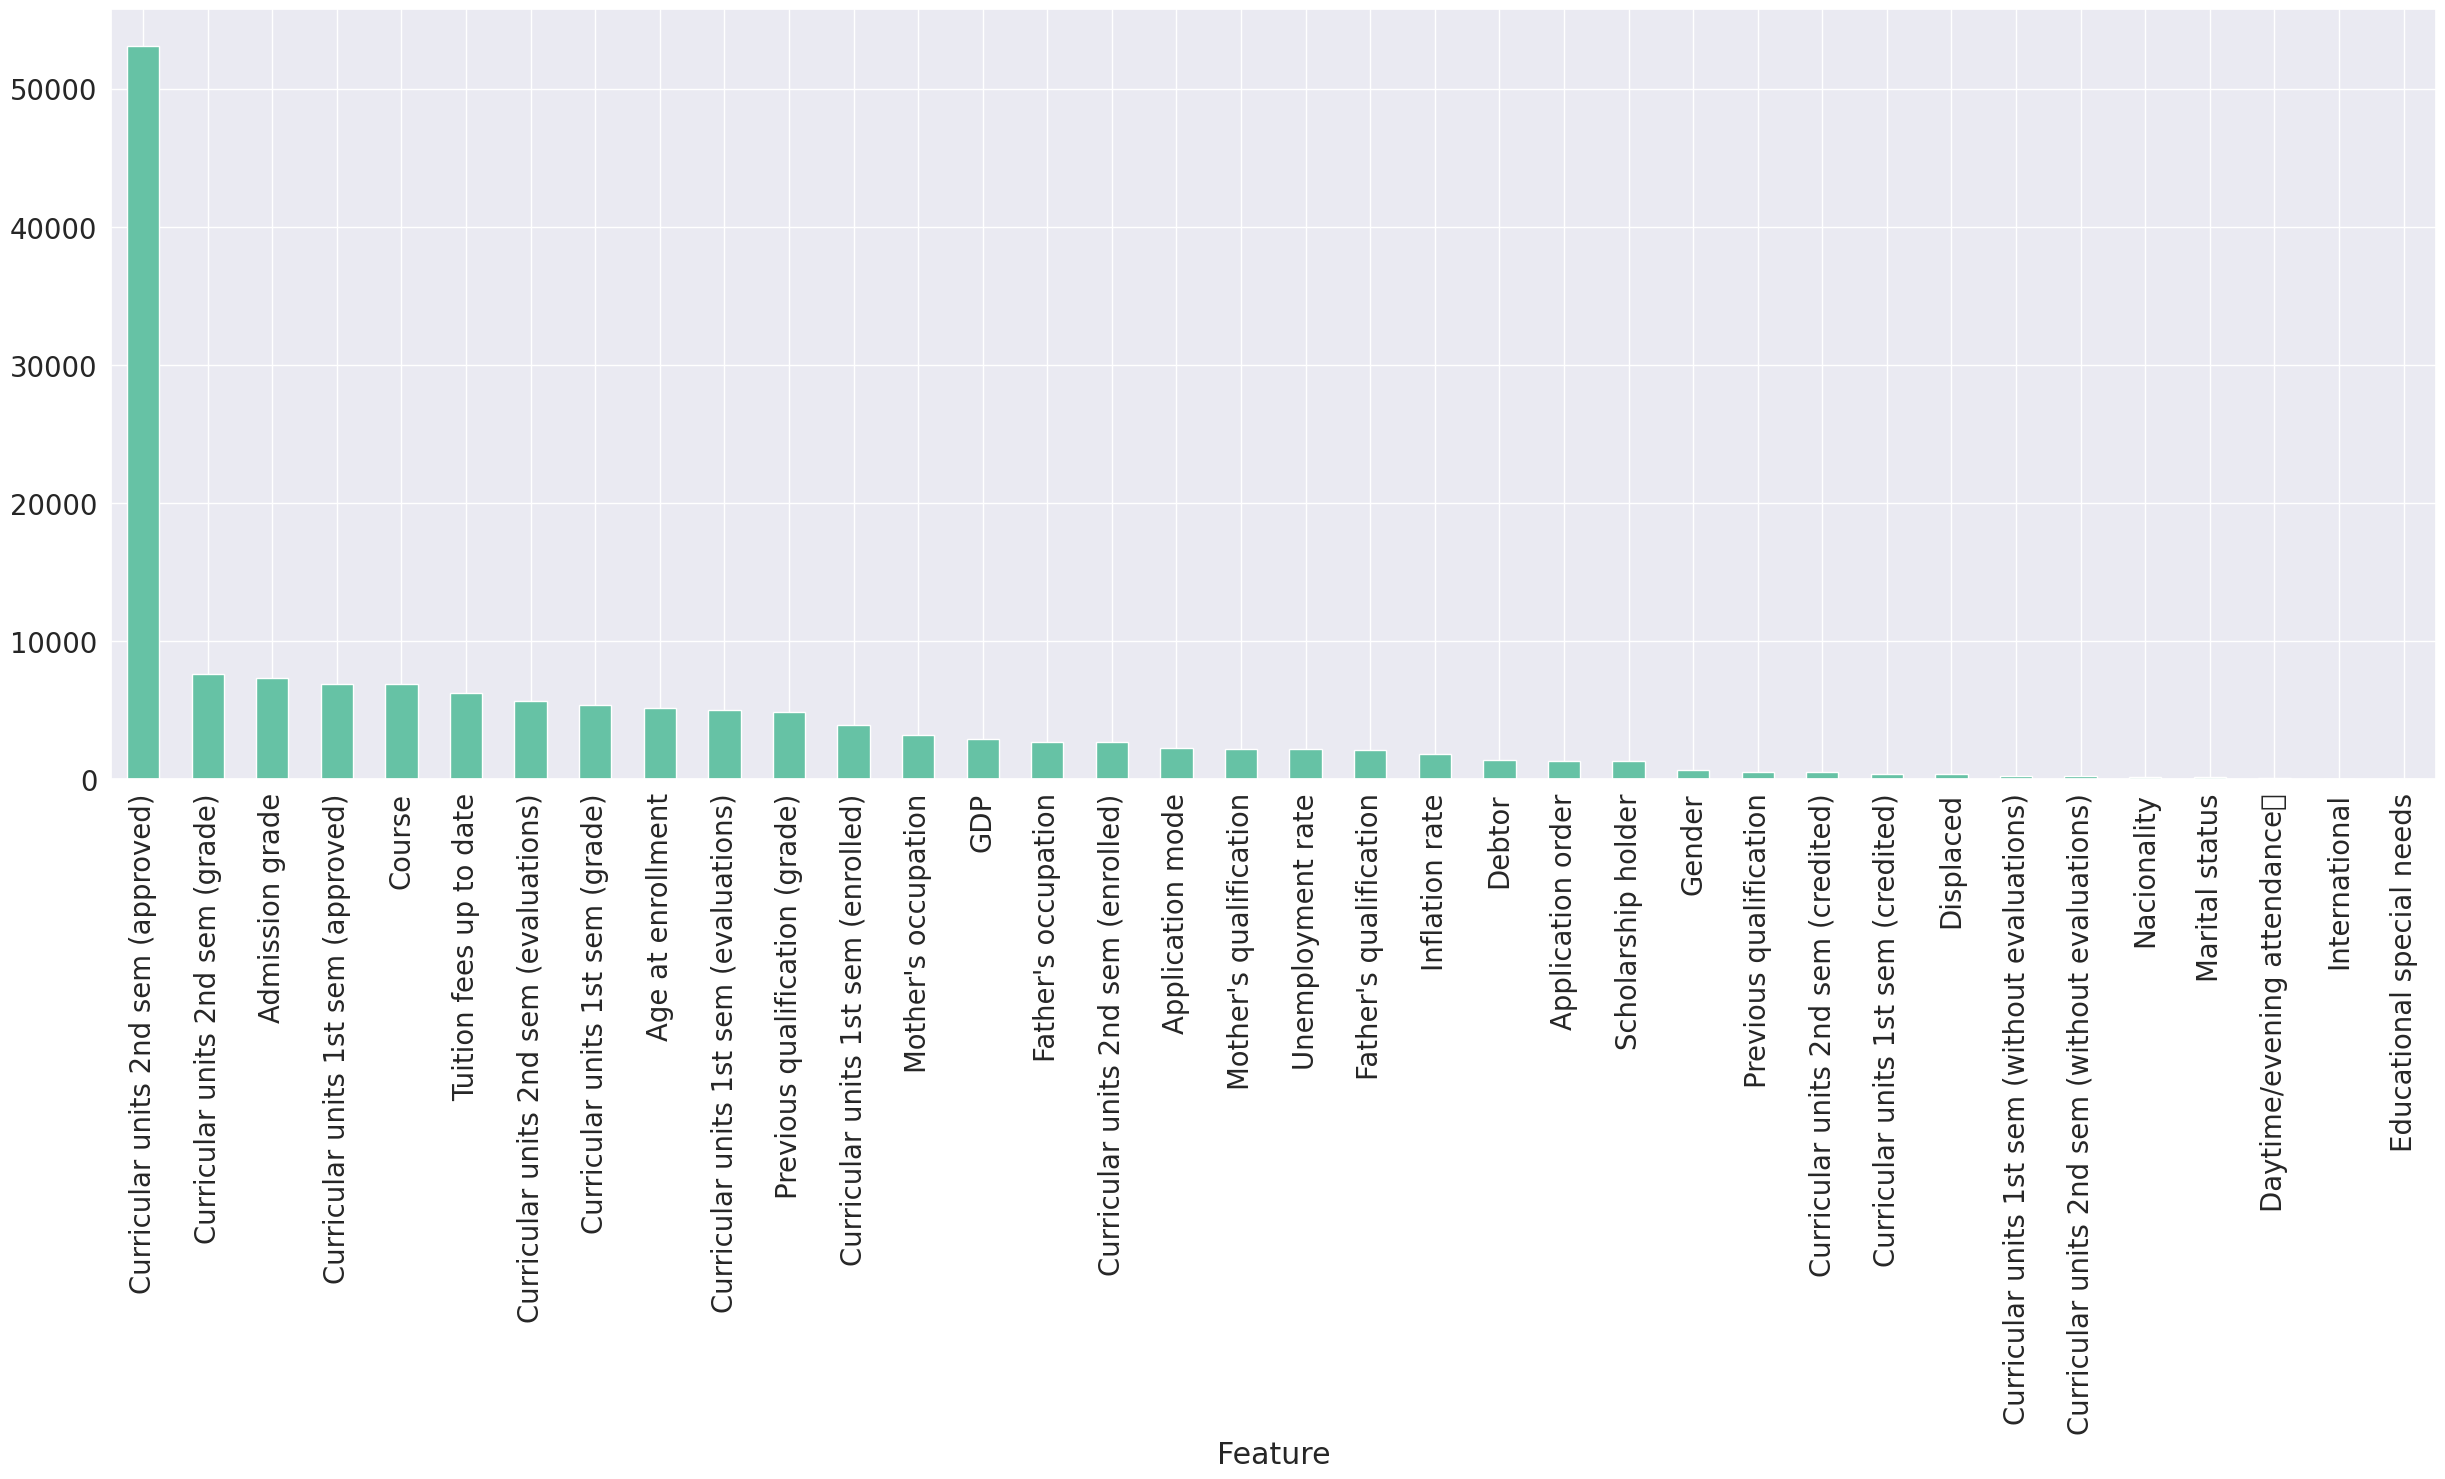

In [59]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

**Выводы:** AutoML хорошо справился с задачей, потому что если подумать логически, то дейтсвительно больше всего влияют зачеты и оценки на отчисление/обучение, а например национальность или пол, не очень важны. и f1_score имеет более менее хорошие оценки.